# Results Evaluation

In [55]:
%run ../scripts/load_df_for_analysis.py
%run ../scripts/data_visualisations.py
%run ../scripts/df_calculations.py
%run ../scripts/significance_tests.py

In [56]:
n_permutations = 1000

## Overall model results

In [57]:
import json

with open('../data/all_results.json', 'r') as f:
    all_results = json.load(f)

In [58]:
def get_best_model_configurations(all_results):
    best_configs = {}
    
    for model_name, configurations in all_results.items():
        best_config = None
        best_balanced_accuracy = -1
        best_config_name = None
        
        for config_name, config_data in configurations.items():
            # Skip configurations ending with "AI_prompt"
            if config_name.endswith('AI_prompt'):
                continue
                
            # Only consider 'all' results
            if 'all' in config_data:
                balanced_accuracy = config_data['all'].get('Balanced Accuracy', -1)
                if balanced_accuracy > best_balanced_accuracy:
                    best_balanced_accuracy = balanced_accuracy
                    best_config = config_data['all']
                    best_config_name = config_name
        
        if best_config is not None:
            best_configs[model_name] = {
                'configuration': best_config_name,
                'balanced_accuracy': best_balanced_accuracy,
                'results': best_config
            }
    
    return best_configs

In [59]:
best_model_configs = get_best_model_configurations(all_results)

print("Best model configurations based on highest Balanced Accuracy (excluding 'AI_prompt'):\n")
for model, data in best_model_configs.items():
    print(f"{model}: {data['configuration']} (Balanced Accuracy: {data['balanced_accuracy']:.3f})")

Best model configurations based on highest Balanced Accuracy (excluding 'AI_prompt'):

gpt-3.5-turbo-0125: only_text_256_20 (Balanced Accuracy: 0.764)
gpt-4.1-nano-2025-04-14: 256_20 (Balanced Accuracy: 0.774)
gpt-4.1-mini-2025-04-14: only_text_1024_20 (Balanced Accuracy: 0.833)
gpt-4.1-2025-04-14: only_text_1024_20 (Balanced Accuracy: 0.856)
llama3.1.70b: only_text_1024_20 (Balanced Accuracy: 0.819)
llama4.scout: only_text_256_20 (Balanced Accuracy: 0.791)


In [60]:
model_names = {
 'gpt-3.5-turbo-0125': 'GPT-3.5 Turbo',
 'gpt-4.1-nano-2025-04-14': 'GPT-4.1 nano',
 'gpt-4.1-mini-2025-04-14': 'GPT-4.1 mini',
 'gpt-4.1-2025-04-14': 'GPT-4.1',
 'llama3.1.70b': 'Llama 3.1 70B',
 'llama4.scout': 'Llama 4 Scout'
 }

Balanced Accuracies and F1-Scores for Label "Unsubstantiated"\nof Best Parameter Configuration for Each Model

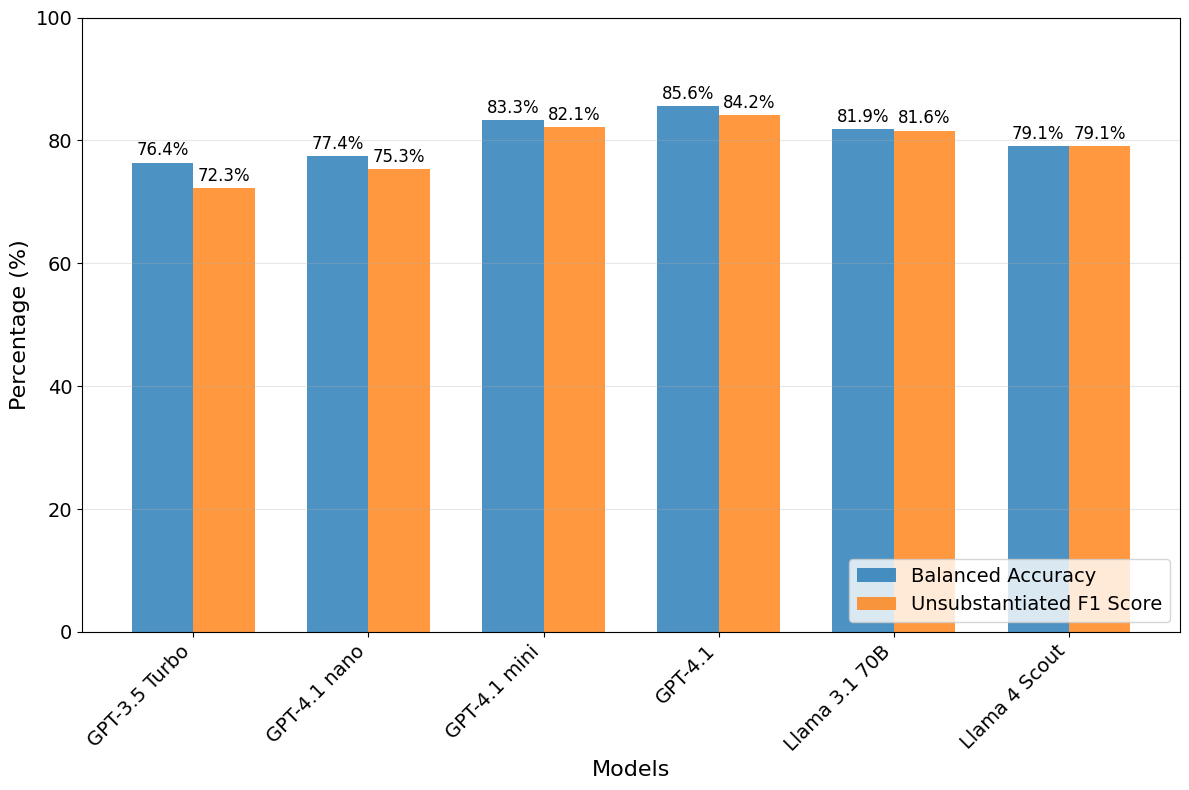

In [61]:
show_best_models_comparison(best_model_configs, model_names=model_names, title='', save_title="best_models_results")

### Comparison of best GPT and best Llama Model (from tested models on this data): <br>GPT 4.1 vs. Llama 3.1:70b

In [62]:
chunking = "1024_20"
only_text = True
model = "gpt-4.1-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt = eval_predictions(df_gpt, include_relabelled_partially=True)
results_gpt_no_partially = eval_predictions(df_gpt, include_relabelled_partially=False)

In [63]:
chunking = "256_20"
only_text = True
model = "llama3.1.70b"
df_llama = load_df_for_analysis(chunking, only_text, model)
results_llama = eval_predictions(df_llama, include_relabelled_partially=True)
results_llama_no_partially = eval_predictions(df_llama, include_relabelled_partially=False)

In [64]:
model_results = {
    "GPT-4.1\n(1024 Token Chunks, with PBTE)": results_gpt,
    "Llama 3.1 70B\n(256 Token Chunks, with PBTE)": results_llama,
}

display_model_results_table(model_results)

,Accuracy,Balanced Accuracy,Precision (Unsubstantiated),Recall (Unsubstantiated),F1 Score (Unsubstantiated),Precision (Substantiated),Recall (Substantiated),F1 Score (Substantiated)
Model,,,,,,,,
"GPT-4.1\n(1024 Token Chunks, with PBTE)",0.858,0.856,0.877,0.809,0.842,0.844,0.902,0.872
"Llama 3.1 70B\n(256 Token Chunks, with PBTE)",0.806,0.810,0.748,0.878,0.808,0.875,0.742,0.803


Comparison of Classification Performance Metrics per Label\nbetween GPT 4.1 and Llama 3.1:70b\non Full Dataset

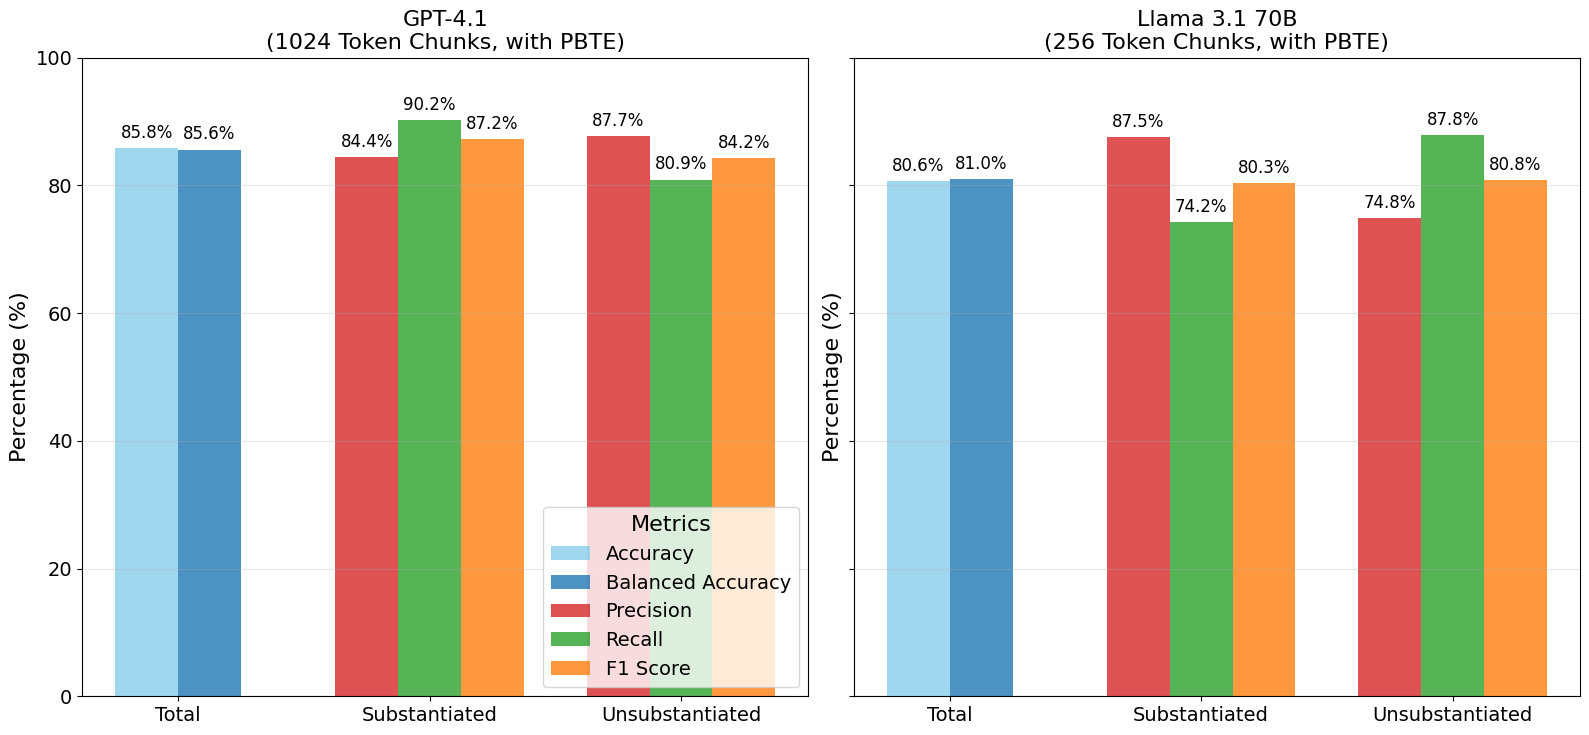

In [65]:
show_metrics_per_label(model_results, "", save_title="detailed_metrics_best_llama_gpt_models")

#### Other models

In [66]:
# Llama 4 Scout
chunking = "256_20"
only_text = True
model = "llama4.scout"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_llama_4_scout = eval_predictions(df_gpt, include_relabelled_partially=True)

Using extracted label (Unsubstantiated) from non JSON text!
Using extracted label (Unsubstantiated) from non JSON text!
Using extracted label (Unsubstantiated) from non JSON text!
Using extracted label (Unsubstantiated) from non JSON text!
Using extracted label (Unsubstantiated) from non JSON text!
Using extracted label (Unsubstantiated) from non JSON text!
Using extracted label (Unsubstantiated) from non JSON text!
Using extracted label (Substantiated) from non JSON text!
Using extracted label (Substantiated) from non JSON text!
Using extracted label (Unsubstantiated) from non JSON text!
Row 136 Model Classification could not be decoded: Expecting value: line 1 column 1 (char 0)
The information you provided is not sufficient for me to provide a detailed response. Please provide more context or information about your topic of interest.
Row 137 Model Classification could not be decoded: Expecting value: line 1 column 1 (char 0)
# Substantiated

The reference article provides a detailed 

In [67]:
# GPT-3.5 Turbo
chunking = "256_20"
only_text = True
model = "gpt-3.5-turbo-0125"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt_35_turbo = eval_predictions(df_gpt, include_relabelled_partially=True)

Row 21 Model Classification could not be decoded: Expecting value: line 1 column 1 (char 0)

Row 21 Model Classification Label is not a valid label: None


In [68]:
# GPT-4.1 nano
chunking = "256_20"
only_text = False
model = "gpt-4.1-nano-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt_41_nano = eval_predictions(df_gpt, include_relabelled_partially=True)

In [69]:
# GPT-4.1 mini
chunking = "1024_20"
only_text = True
model = "gpt-4.1-mini-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt_41_mini = eval_predictions(df_gpt, include_relabelled_partially=True)

In [70]:
other_model_results = {
    "GPT-3.5 Turbo\n(256 Token Chunks, with PBTE)": results_gpt_35_turbo,
    "GPT-4.1 nano\n(256 Token Chunks, no PBTE)": results_gpt_41_nano,
    "GPT-4.1 mini\n(1024 Token Chunks, with PBTE)": results_gpt_41_mini,
    "GPT-4.1\n(1024 Token Chunks, with PBTE)": results_gpt,
    "Llama 3.1 70B\n(256 Token Chunks, with PBTE)": results_llama,
    "Llama 4 Scout\n(256 Token Chunks, with PBTE)": results_llama_4_scout,
}

display_model_results_table(other_model_results)

,Accuracy,Balanced Accuracy,Precision (Unsubstantiated),Recall (Unsubstantiated),F1 Score (Unsubstantiated),Precision (Substantiated),Recall (Substantiated),F1 Score (Substantiated)
Model,,,,,,,,
"GPT-3.5 Turbo\n(256 Token Chunks, with PBTE)",0.773,0.764,0.839,0.635,0.723,0.738,0.894,0.809
"GPT-4.1 nano\n(256 Token Chunks, no PBTE)",0.777,0.774,0.778,0.730,0.753,0.777,0.818,0.797
"GPT-4.1 mini\n(1024 Token Chunks, with PBTE)",0.834,0.833,0.825,0.817,0.821,0.842,0.848,0.845
"GPT-4.1\n(1024 Token Chunks, with PBTE)",0.858,0.856,0.877,0.809,0.842,0.844,0.902,0.872
"Llama 3.1 70B\n(256 Token Chunks, with PBTE)",0.806,0.810,0.748,0.878,0.808,0.875,0.742,0.803
"Llama 4 Scout\n(256 Token Chunks, with PBTE)",0.785,0.791,0.725,0.870,0.791,0.862,0.712,0.780


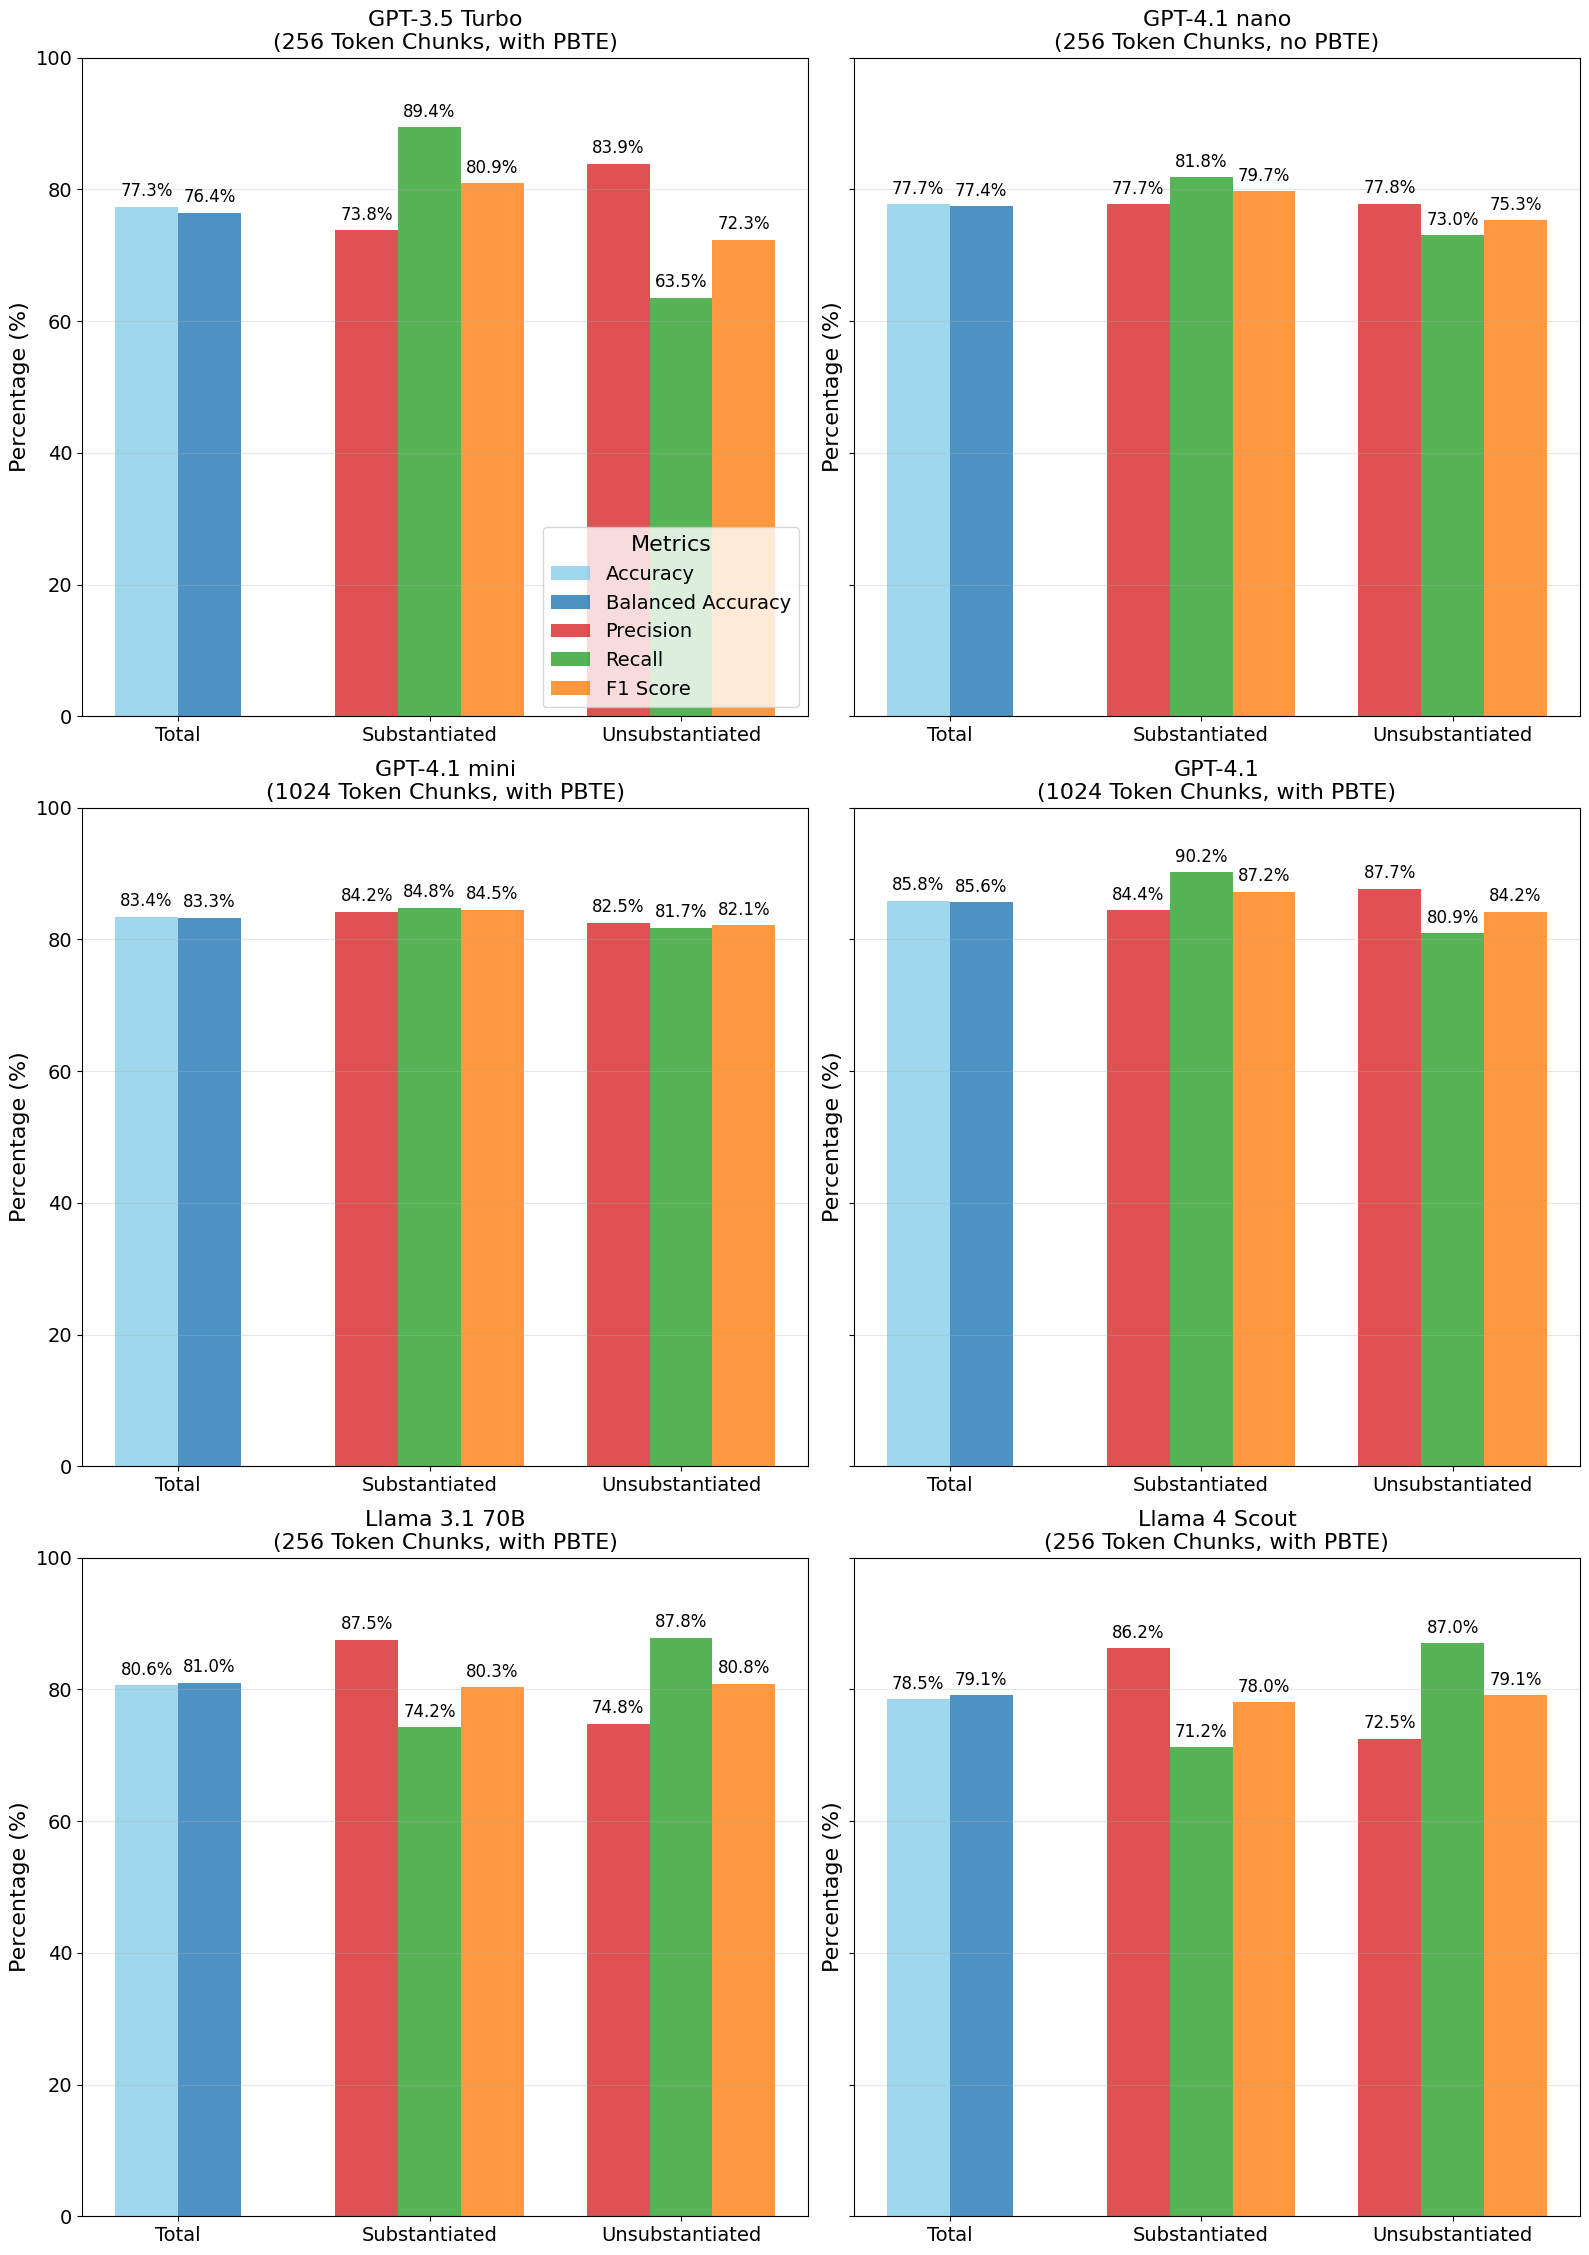

In [71]:
show_metrics_per_label(other_model_results, "", save_title="detailed_metrics_other_llama_gpt_models")

## Comparison: Evaluation per Annotation Attribute

In [72]:
def attribute_predictions_per_model(model_dfs, attribute, relabelled_partially=False, group_numbers_from=False):
    results = {}
    for model_name, df in model_dfs.items():
        results[model_name] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=True, group_numbers_from=group_numbers_from)
        if relabelled_partially:
            results[model_name + " (exclude relabelled partially)"] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=False, group_numbers_from=group_numbers_from)
    return results

In [73]:
def fisher_exact_for_attribute(df, attribute, group_numbers_from=False):
    results = {}
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    for group_name, attribute_values_list in attribute_groups:
        results[group_name] = calc_fisher_exact_total_sub_unsub(
            eval_attribute_subset_vs_rest(df, attribute, attribute_values_list)
        )
    display_fishers_exact_test_results(results)
    return results

In [74]:
def fisher_exact_overall_for_attribute(df, attribute, group_numbers_from=False):
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    evals = eval_per_attribute_value(df, attribute, attribute_groups)
    results = calc_fisher_exact_overall_total_sub_unsub(evals, [group_name for group_name, _ in attribute_groups])
    display_fisher_exact_overall_test_results(results)
    return results

In [75]:
def chi_squared_for_attribute(df, attribute, group_numbers_from=False):
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    evals = eval_per_attribute_value(df, attribute, attribute_groups)
    results = calc_chi_squared_total_sub_unsub(evals, [group_name for group_name, _ in attribute_groups])
    display_chi_squared_test_results(results)
    return results

In [76]:
def permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations):
    results = calc_permutation_test_total_sub_unsub(df, attribute, group_numbers_from, n_permutations)
    display_permutation_test_results(results)
    return results

In [77]:
import time

def significance_tests_for_attribute(df, model_name, attribute, group_numbers_from=False):
    global n_permutations

    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    # num_groups = len(attribute_groups)
    
    results = {}
    print(f"---- ## Significance tests results for {model_name} on attribute '{attribute}': ## ----")

    # Fishers exact test (per attribute value when compared to rest)
    # if num_groups > 2:
    #     print(f"Fisher's exact test results (per attribute value when compared to rest):")
    #     current_time = time.time()
    #     fisher_exact_results = fisher_exact_for_attribute(df, attribute, group_numbers_from)
    #     results['Fisher Exact'] = fisher_exact_results
    #     print(f"Time taken for Fisher's exact test: {time.time() - current_time:.2f} seconds\n")

    # Fishers exact test (overall comparison)
    print(f"Fisher's exact test results (comparison over all attribute values):")
    current_time = time.time()
    fisher_exact_overall_results = fisher_exact_overall_for_attribute(df, attribute, group_numbers_from)
    results['Fisher Exact Overall'] = fisher_exact_overall_results
    print(f"Time taken for overall Fisher's exact test: {time.time() - current_time:.2f} seconds\n")

    # # Chi-Squared test (overall comparison)
    # print(f"Chi-squared test results (comparison over all attribute values):")
    # current_time = time.time()
    # chi_squared_results = chi_squared_for_attribute(df, attribute, group_numbers_from)
    # results['Chi-Squared'] = chi_squared_results
    # print(f"Time taken for Chi-squared test: {time.time() - current_time:.2f} seconds\n")

    # Permutation test (overall comparison)
    print(f"Permutation test results (comparison per metric over {n_permutations} permutations):")
    current_time = time.time()
    permutation_test_results = permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations)
    results['Permutation Test'] = permutation_test_results
    print(f"Time taken for permutation test: {time.time() - current_time:.2f} seconds\n")

    print("\n\n")
    return results

In [78]:
model_dfs = {  
    "GPT-4.1": df_gpt
}
analyzed_df = df_gpt
analyzed_model = "GPT-4.1"
significance_tests_results = {}
results_per_attribute = {}

### Reference Only

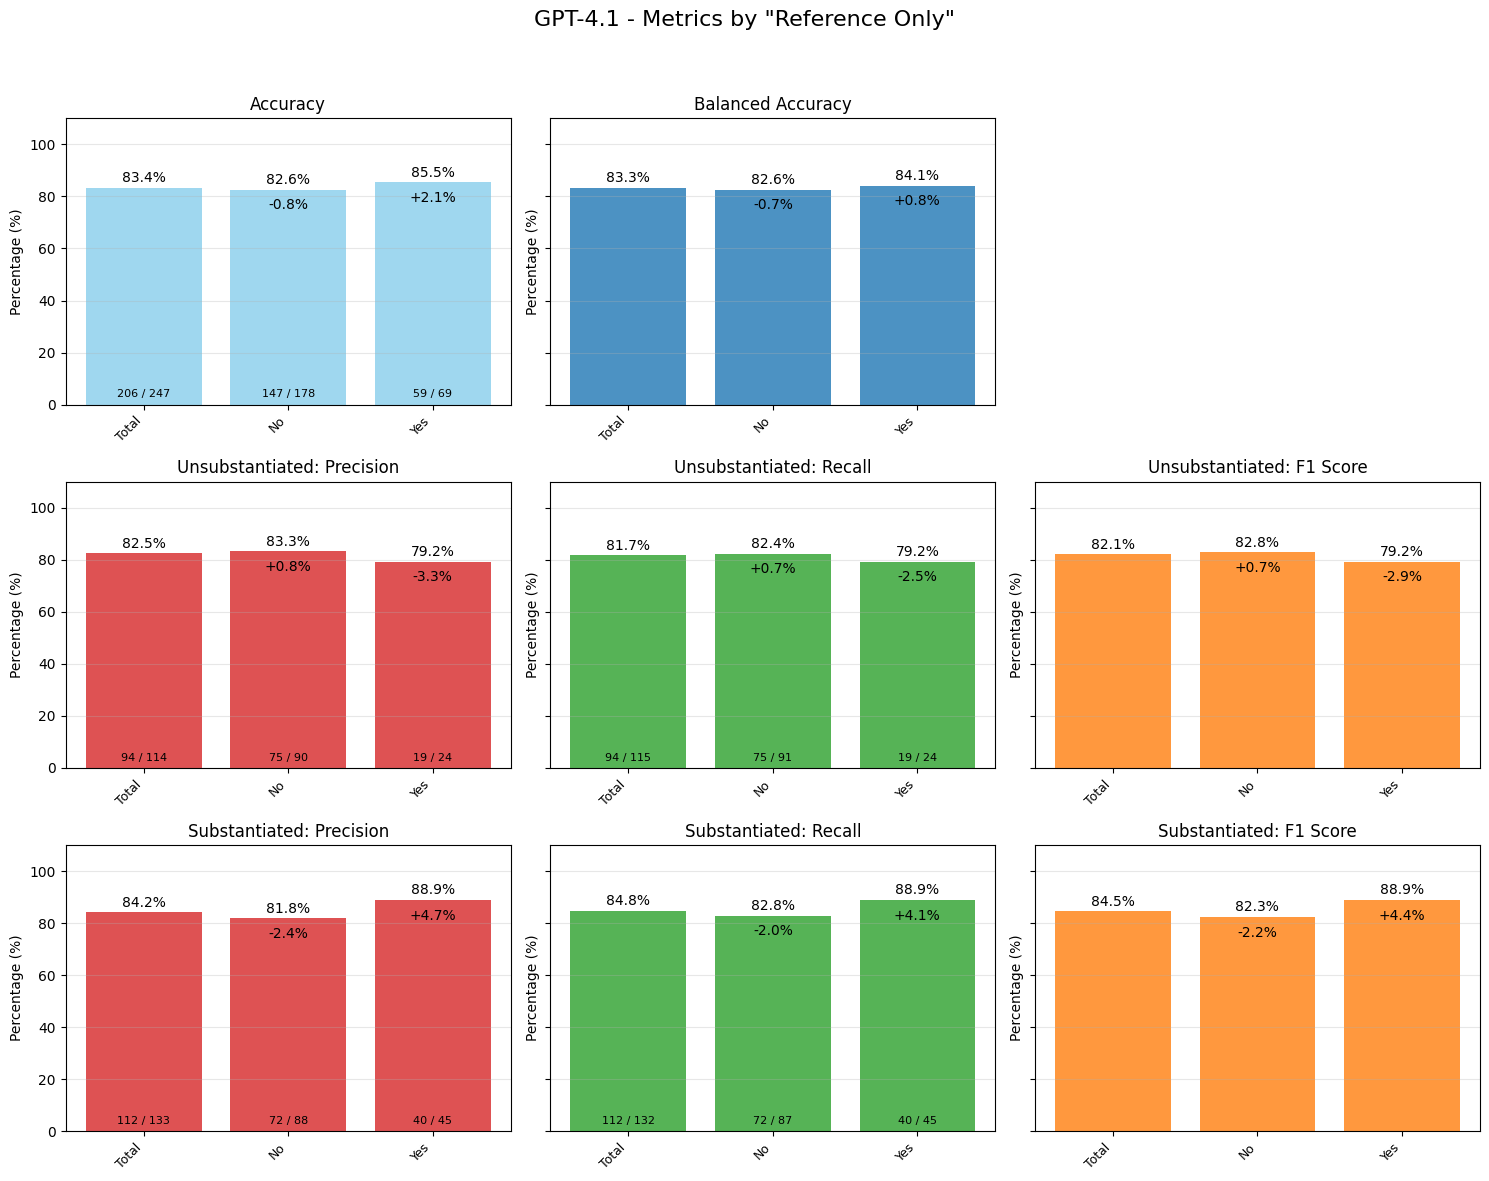

In [79]:
attribute = "Reference Only"
results = attribute_predictions_per_model(model_dfs, attribute)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [80]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Reference Only': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,1.2442,0.7040,0.8107,0.7681,1.6667,0.4470


Time taken for overall Fisher's exact test: 0.02 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000600,0.7810,N/A,N/A,N/A,N/A
Accuracy,-0.000500,0.6140,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.001200,0.6000,0.000000,0.3350
Recall,N/A,N/A,-0.001300,0.6920,-0.000300,0.3710
F1 Score,N/A,N/A,-0.000700,0.5810,0.000300,0.2390


Time taken for permutation test: 10.05 seconds






### Claim Contains Number or Formula

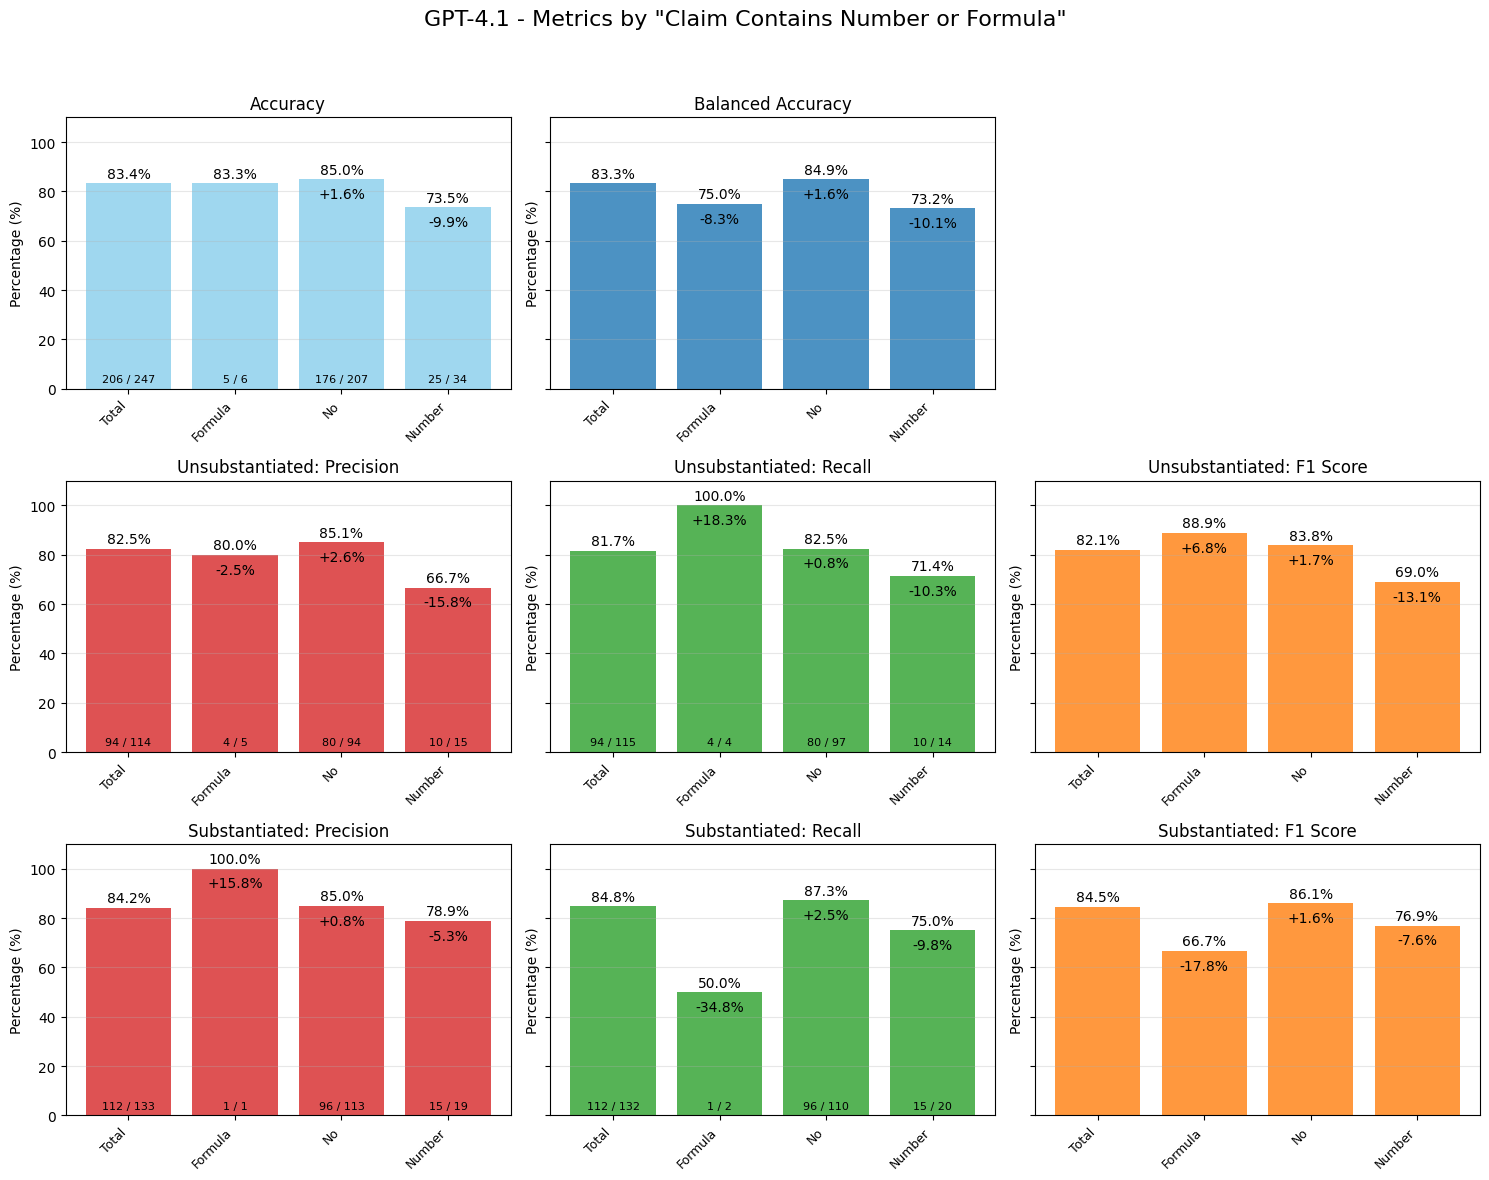

In [81]:
attribute = "Claim Contains Number or Formula"
results = attribute_predictions_per_model(model_dfs, attribute)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [82]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model,attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Contains Number or Formula': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Statistic,Total P-value,Unsubstantiated Statistic,Unsubstantiated P-value,Substantiated Statistic,Substantiated P-value
0,0.0201,0.2042,0.0718,0.3986,0.0245,0.0971


Time taken for overall Fisher's exact test: 0.03 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.006500,0.6510,N/A,N/A,N/A,N/A
Accuracy,-0.003900,0.6510,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.016000,0.8480,-0.005800,0.3770
Recall,N/A,N/A,-0.007600,0.2950,0.010100,0.1350
F1 Score,N/A,N/A,-0.010500,0.4340,-0.004200,0.3760


Time taken for permutation test: 10.42 seconds






### Amount Citations in Sentence

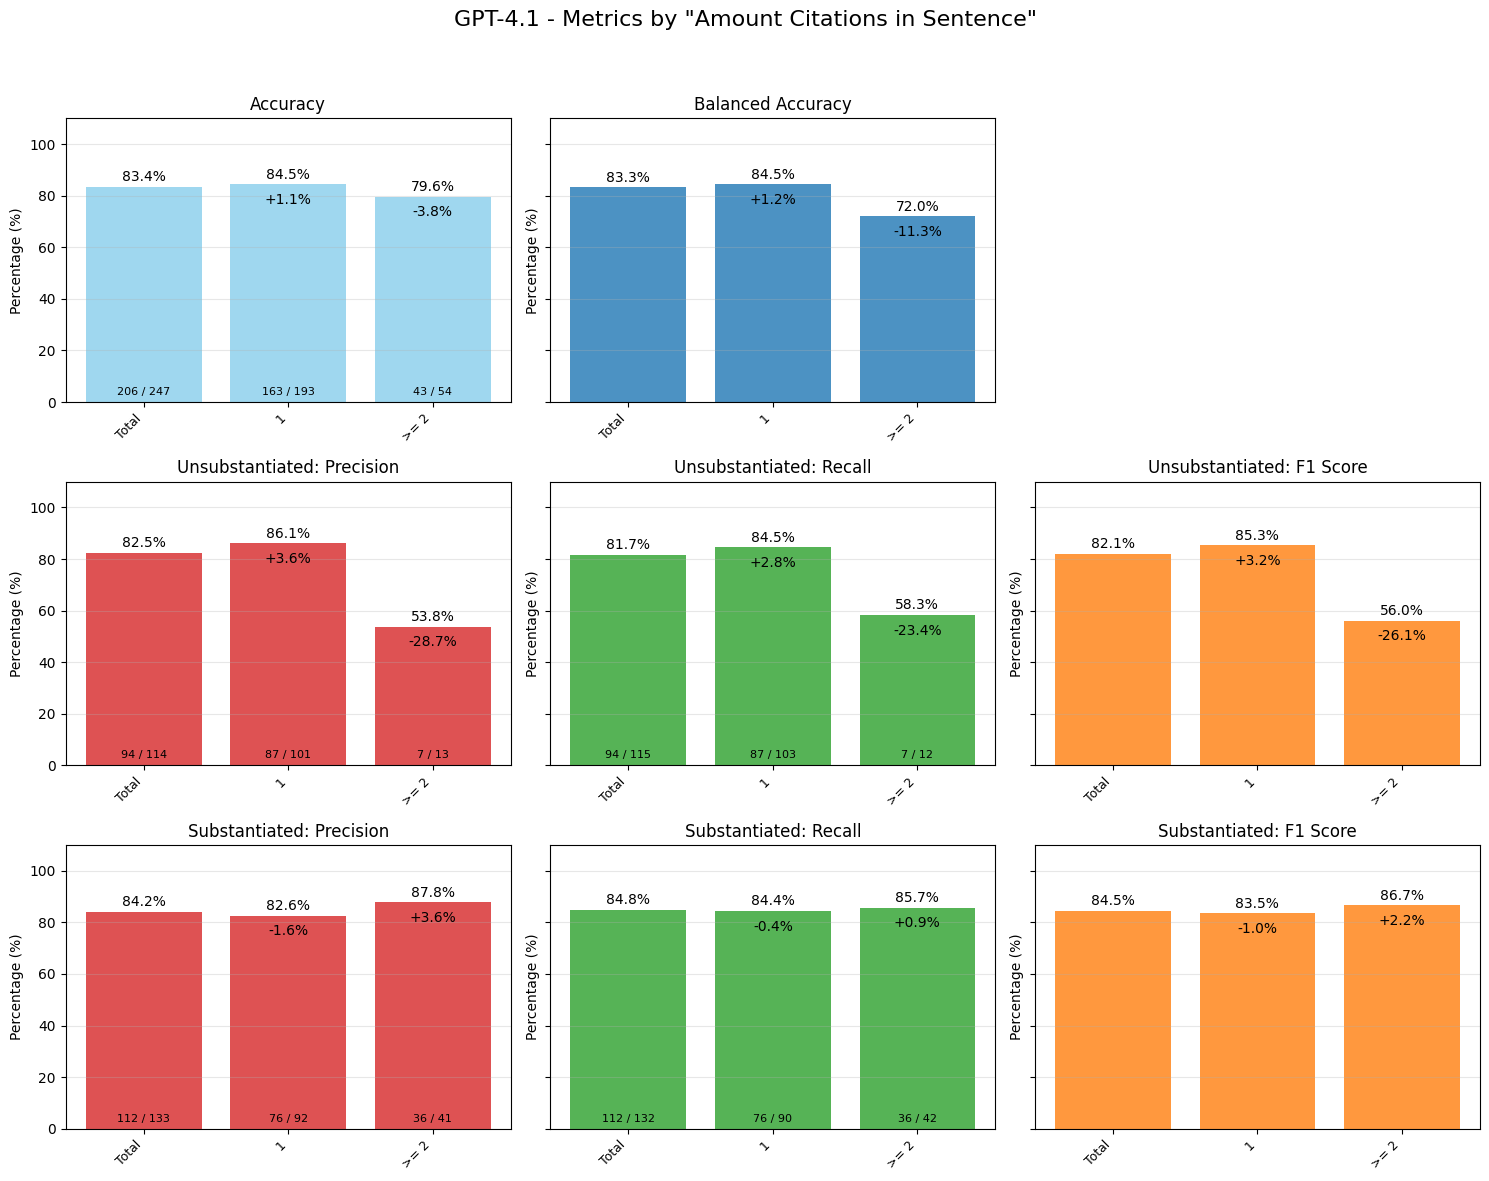

In [83]:
attribute = "Amount Citations in Sentence"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [84]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Citations in Sentence': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,1.3899,0.4112,3.8839,0.0421,0.9048,1.0000


Time taken for overall Fisher's exact test: 0.02 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.003100,0.0230,N/A,N/A,N/A,N/A
Accuracy,-0.000200,0.4040,N/A,N/A,N/A,N/A
Precision,N/A,N/A,0.024300,0.0000,-0.000600,0.4760
Recall,N/A,N/A,0.015400,0.0030,-0.001400,0.8420
F1 Score,N/A,N/A,0.020500,0.0000,-0.000500,0.5900


Time taken for permutation test: 9.96 seconds






### Amount References for Claim

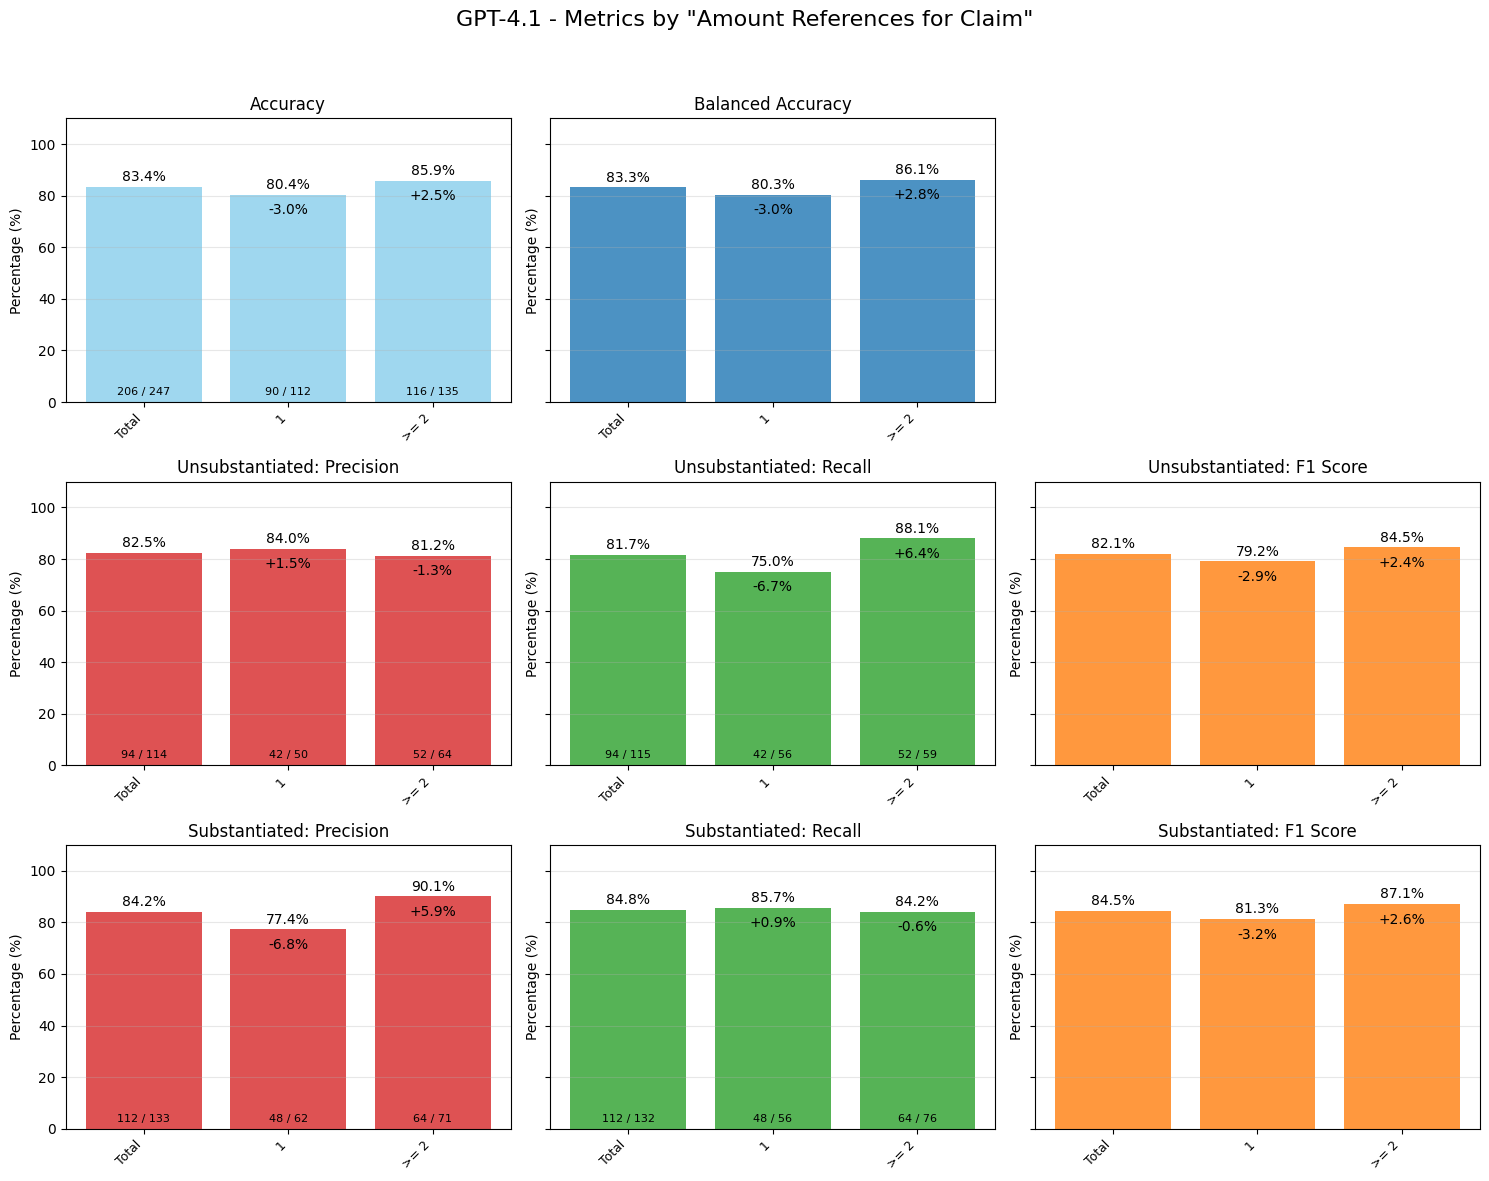

In [85]:
attribute = "Amount References for Claim"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [86]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount References for Claim': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,0.6701,0.3029,0.4038,0.0914,1.1250,1.0000


Time taken for overall Fisher's exact test: 0.02 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000200,0.2450,N/A,N/A,N/A,N/A
Accuracy,0.000200,0.3020,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.001000,0.6940,0.002900,0.0600
Recall,N/A,N/A,0.002900,0.0850,-0.000800,0.8320
F1 Score,N/A,N/A,-0.000100,0.3460,0.000200,0.2500


Time taken for permutation test: 9.99 seconds






### Claim Sentence Structure

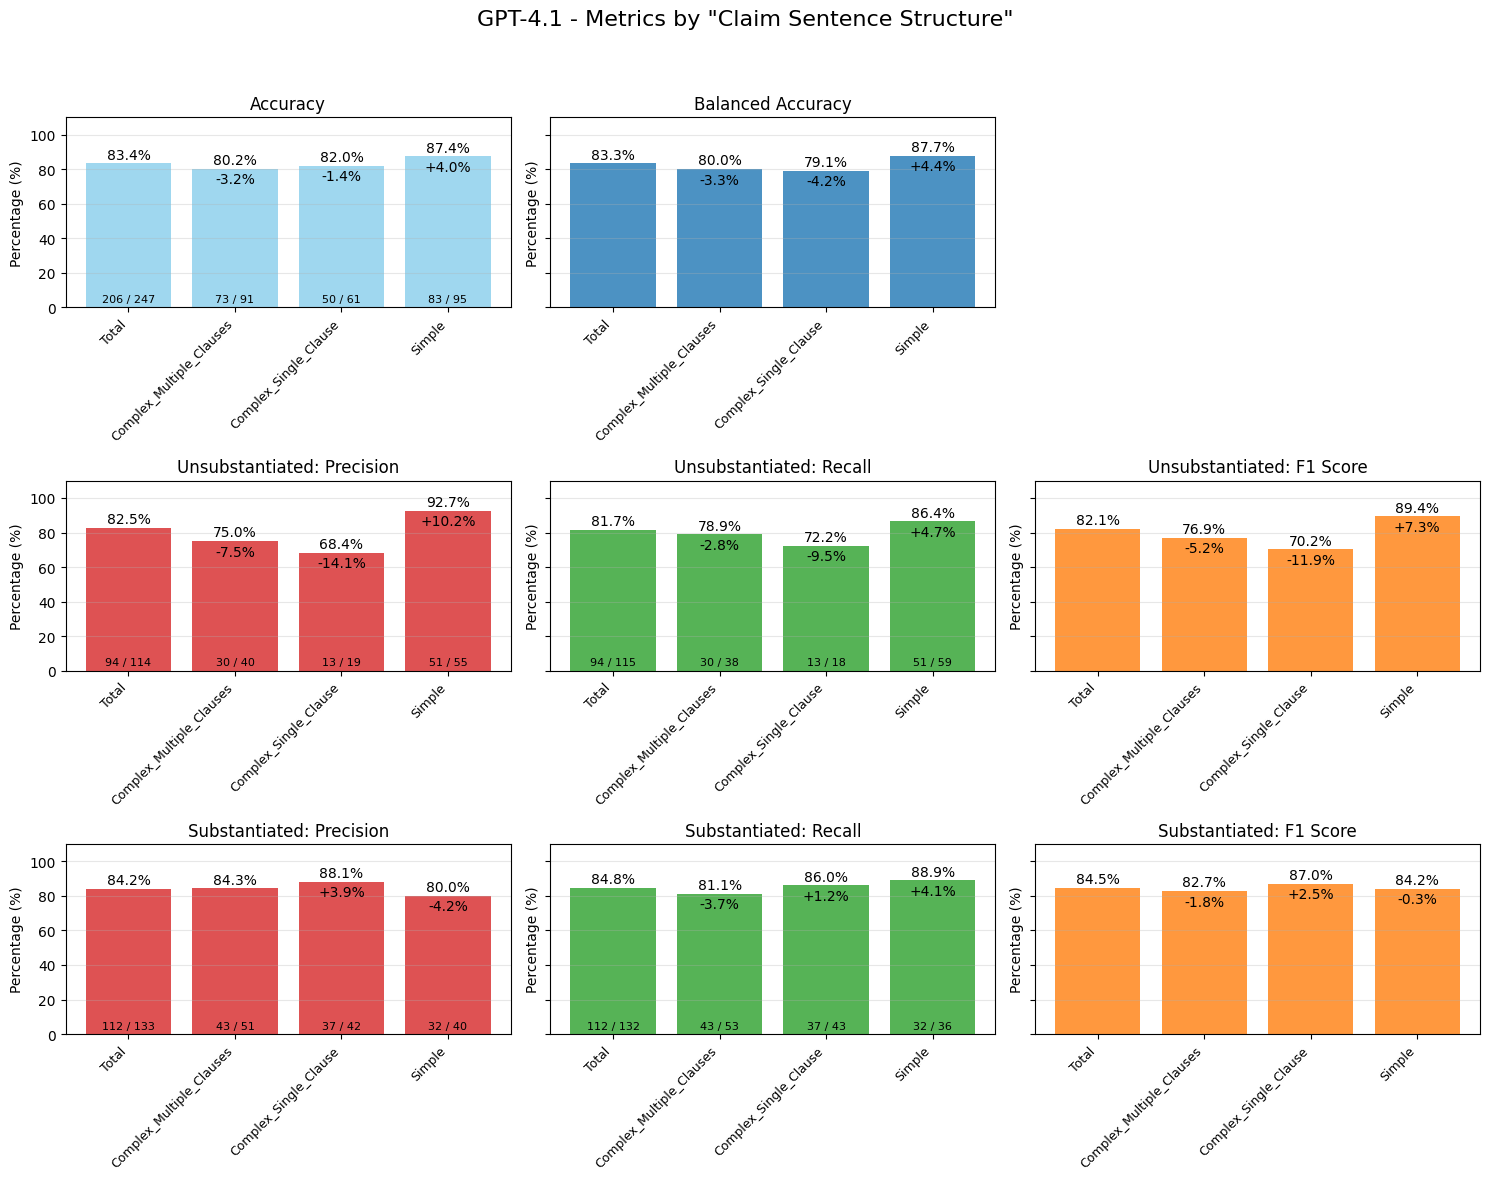

In [87]:
attribute = "Claim Sentence Structure"
results = attribute_predictions_per_model(model_dfs, attribute)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [88]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Sentence Structure': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Statistic,Total P-value,Unsubstantiated Statistic,Unsubstantiated P-value,Substantiated Statistic,Substantiated P-value
0,0.0097,0.3829,0.0176,0.3416,0.0301,0.5893


Time taken for overall Fisher's exact test: 0.03 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000200,0.3050,N/A,N/A,N/A,N/A
Accuracy,-0.000300,0.4520,N/A,N/A,N/A,N/A
Precision,N/A,N/A,0.007700,0.0210,-0.001000,0.5670
Recall,N/A,N/A,0.000600,0.2970,-0.001100,0.5830
F1 Score,N/A,N/A,0.004600,0.0290,-0.000900,0.7470


Time taken for permutation test: 10.38 seconds






### Amount Claims to Substantiate

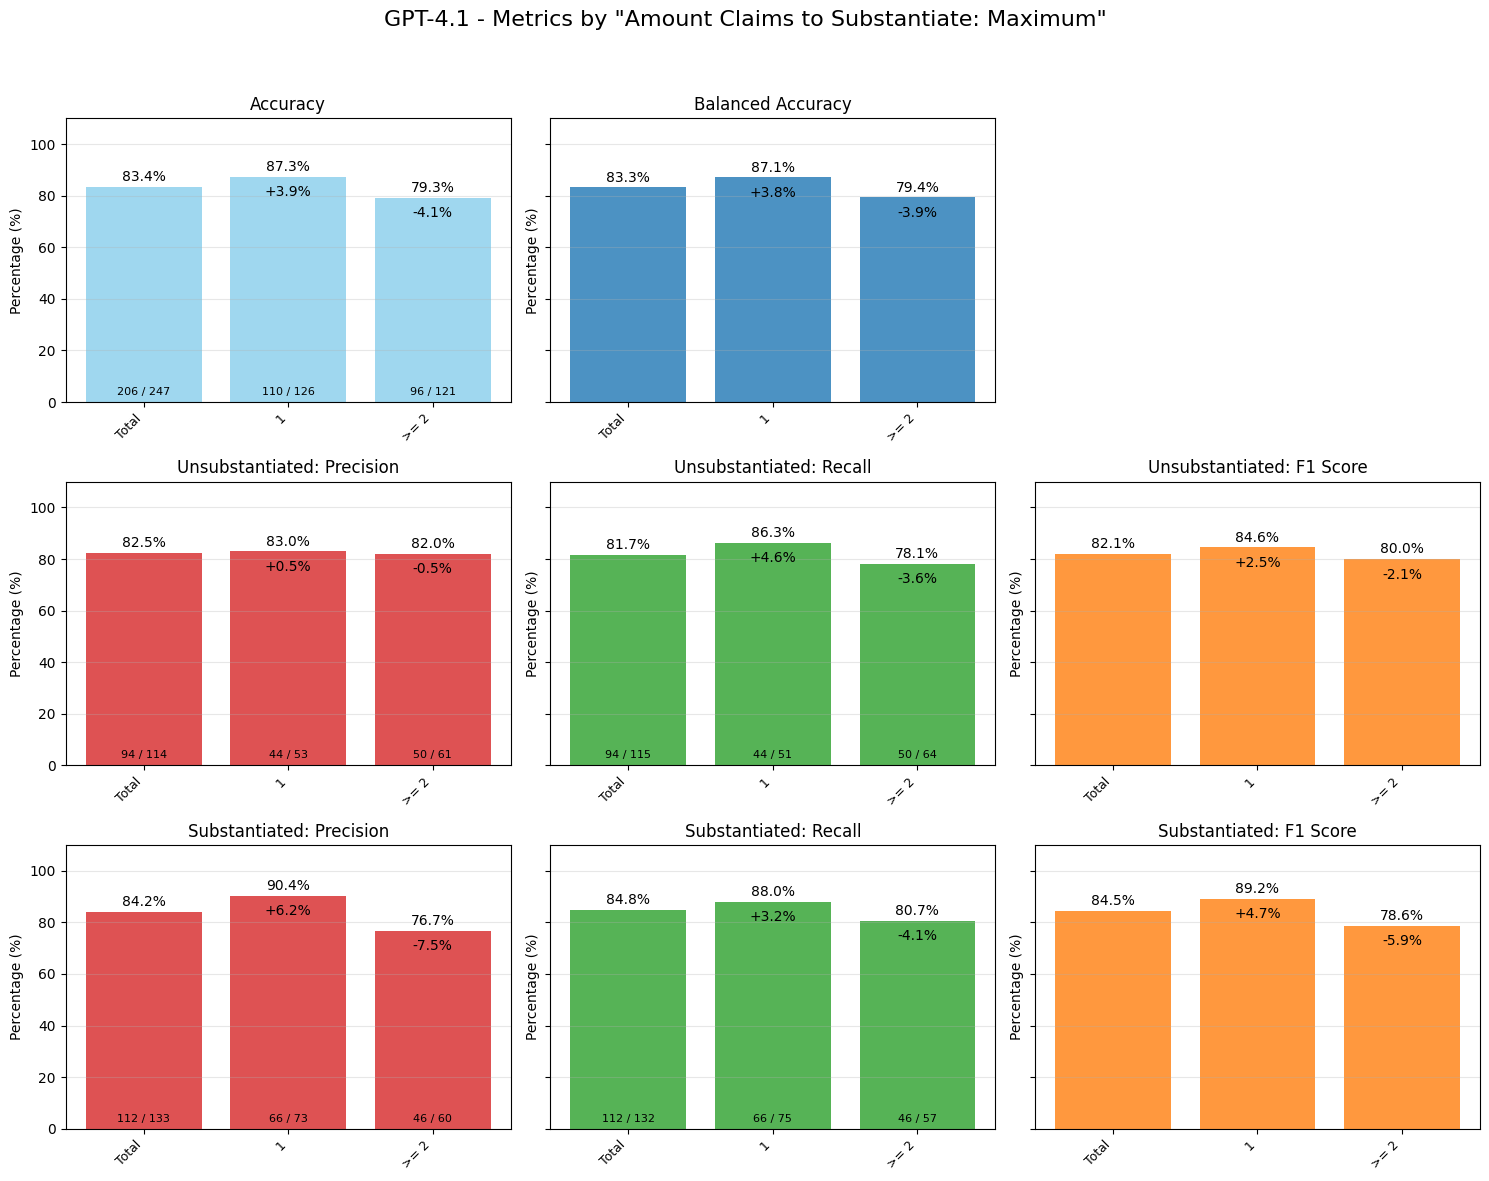

In [89]:
attribute = "Amount Claims to Substantiate: Maximum"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [90]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Claims to Substantiate: Maximum': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,1.7904,0.1231,1.7600,0.3339,1.7536,0.3277


Time taken for overall Fisher's exact test: 0.02 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000900,0.1210,N/A,N/A,N/A,N/A
Accuracy,0.001000,0.1230,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.001200,0.8850,0.003600,0.0430
Recall,N/A,N/A,0.000300,0.2860,0.000300,0.2440
F1 Score,N/A,N/A,-0.000300,0.4250,0.002200,0.0340


Time taken for permutation test: 9.96 seconds






## Overall Plot of Metric Differences

In [1]:
%run ../scripts/load_df_for_analysis.py
%run ../scripts/data_visualisations.py
%run ../scripts/df_calculations.py
%run ../scripts/significance_tests.py

In [2]:
# import json

# # Save results_per_attribute to JSON file
# with open('../data/results_per_attribute.json', 'w') as f:
#     json.dump(results_per_attribute, f, indent=2)

# print("Results saved to ../data/results_per_attribute.json")

In [3]:
import json

# Load results_per_attribute from JSON file
with open('../data/results_per_attribute.json', 'r') as f:
    results_per_attribute = json.load(f)

print("Results loaded from ../data/results_per_attribute.json")

Results loaded from ../data/results_per_attribute.json


In [4]:
attribute_names = {
    'Amount Citations in Sentence': 'Amount Citations in Statement',
    'Amount References for Claim': 'Amount References for Main Citation',
    'Amount Claims to Substantiate: Maximum': 'Amount Claims to Substantiate (Maximum)',
    'Claim Sentence Structure': 'Citation Sentence Structure',
    'Claim Contains Number or Formula': 'Claim Contains Number or Formula',
    'Reference Only': 'Simple Topical Reference'
}

attribute_value_orders = {
    'Claim Sentence Structure': {
        'Simple': 'Simple', 
        'Complex_Single_Clause': 'Complex_\nSingle_\nClause', 
        'Complex_Multiple_Clauses': 'Complex_\nMultiple_\nClauses'
    },
    'Claim Contains Number or Formula': ['No', 'Number', 'Formula']
}

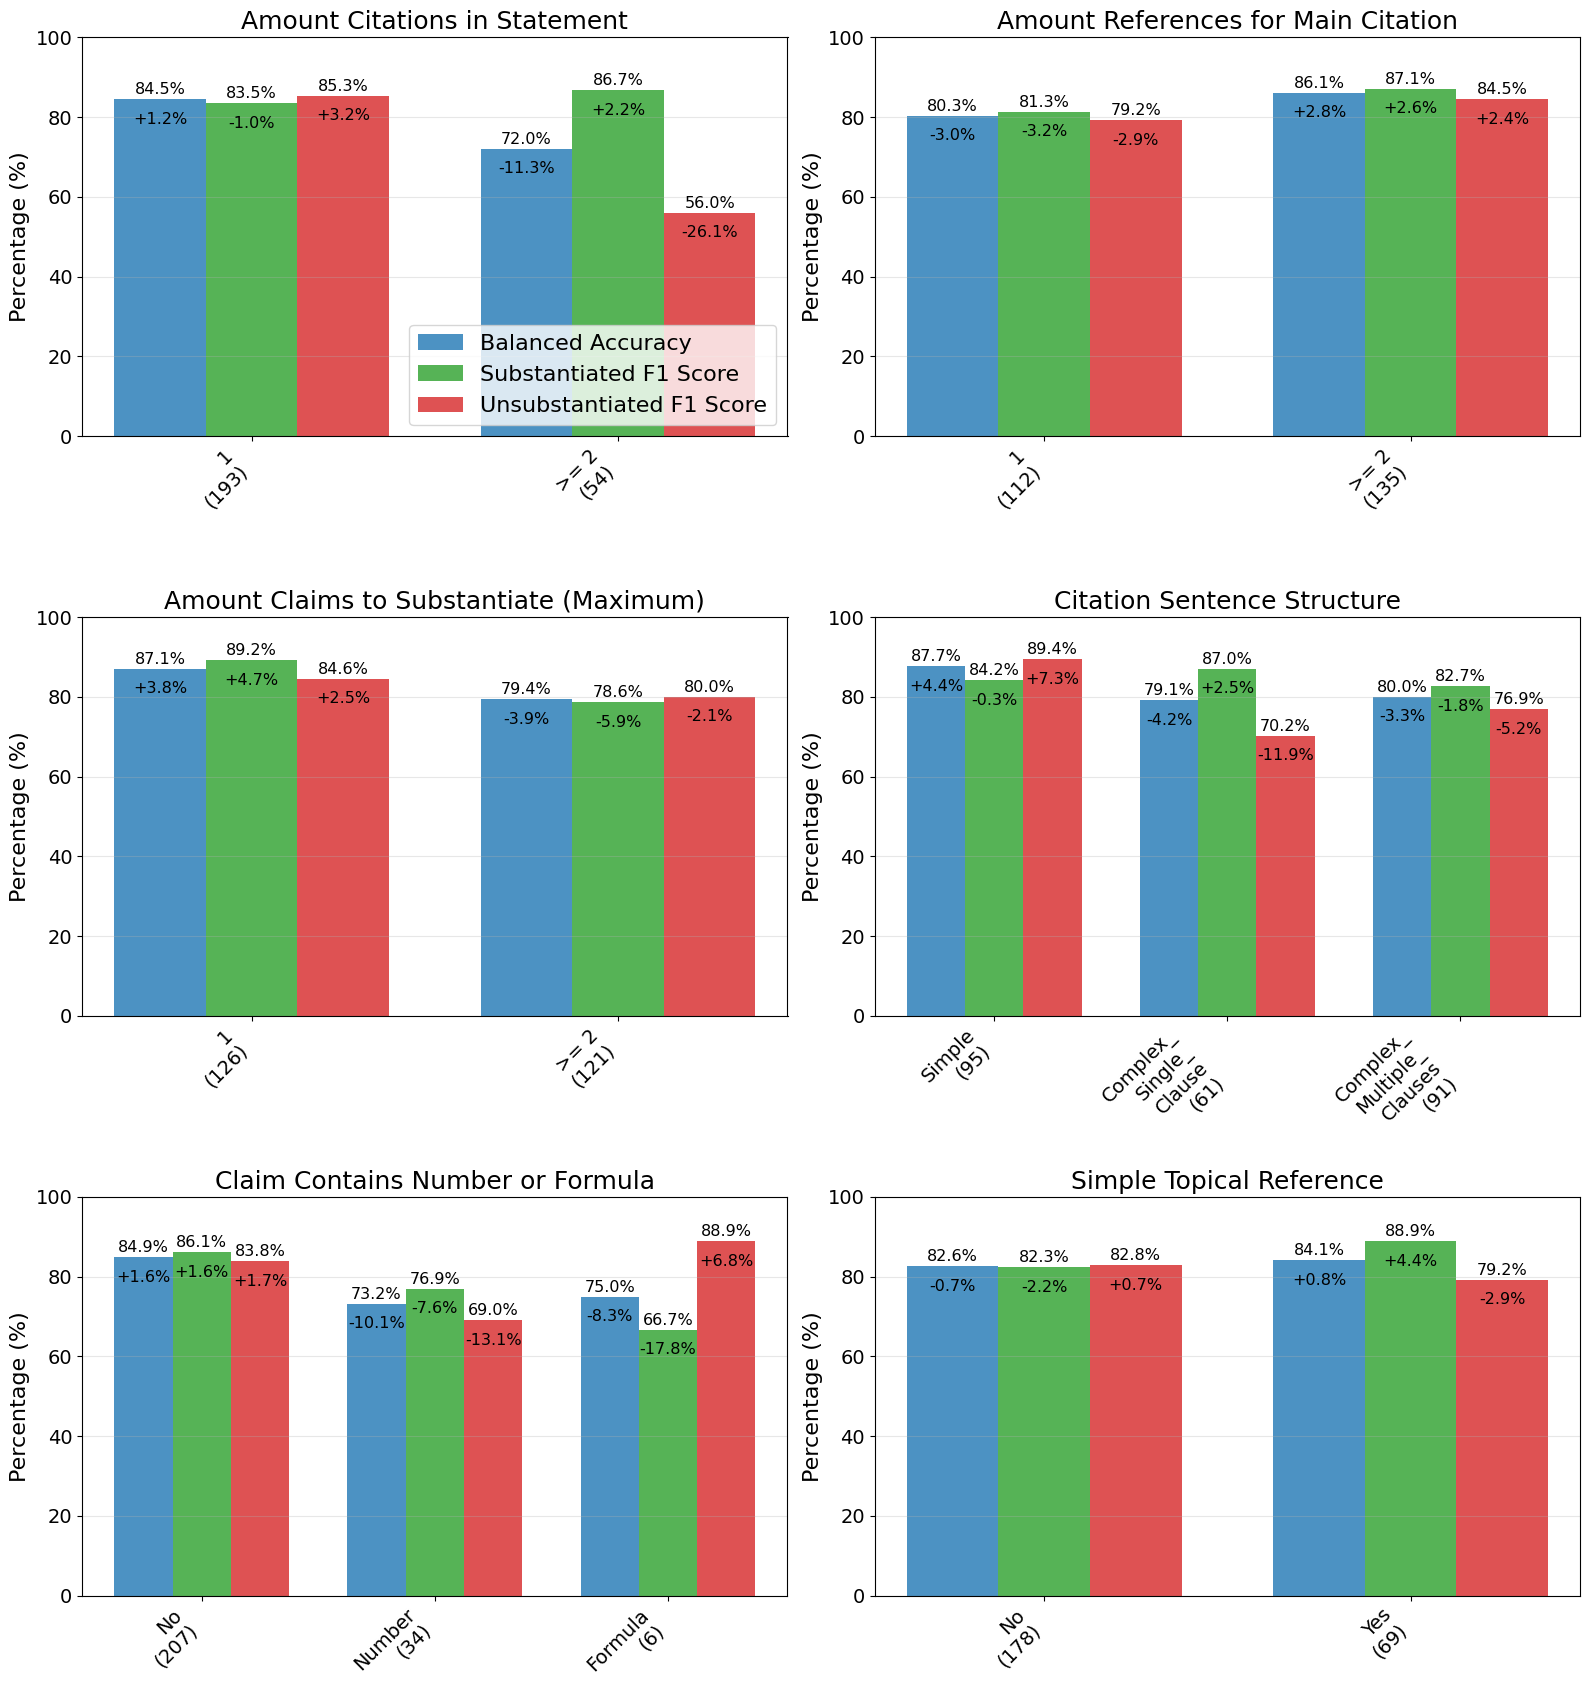


Total Metrics:
--------------------------------------------------
Balanced Accuracy: 83.3%
Substantiated F1: 84.5%
Unsubstantiated F1: 82.1%


In [5]:
show_metrics_by_annotation_attributes(results_per_attribute, "performance_by_attribute_values", attribute_names=attribute_names, attribute_value_orders=attribute_value_orders, show_totals=False)

## Overall Evaluation of Significance Test Results

In [96]:
significance_results = extract_p_values(significance_tests_results)

In [97]:
attributes = list(significance_results.keys())
attributes

['Reference Only',
 'Claim Contains Number or Formula',
 'Amount Citations in Sentence',
 'Amount References for Claim',
 'Claim Sentence Structure',
 'Amount Claims to Substantiate: Maximum']

In [98]:
p_values_by_test = reorganize_p_values_by_test_type(significance_results)

### Multiple Testing Adjustment using Holm Procedure

#### Fisher's Exact Test Results (per attribute value against rest)

In [99]:
# def combine_dict_hierarchies(dict):
#     combined = {}
#     for attribute, attribute_results in dict.items():
#         for attribute_value, p_value in attribute_results.items():
#             combined[f"{attribute}, {attribute_value}"] = p_value
#     return combined

In [100]:
# def combined_dict_to_list(combined_dict):
#     l = []
#     for key, value in combined_dict.items():
#         l.append((key, value))
#     return l

In [101]:
# fisher_exact_results = p_values_by_test['Fisher Exact']

# fisher_exact_results_combined_dict = {label_set:combine_dict_hierarchies(results) for label_set, results in fisher_exact_results.items()}

# for label_set in fisher_exact_results:
#     print(f"---- Label set: {label_set} ----")
#     rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(combined_dict_to_list(fisher_exact_results_combined_dict[label_set]))
#     print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, fisher_exact_results_combined_dict, label_set)

#### Overall Fisher's Exact Test Results

In [102]:
def get_value_by_attribute(data, attribute_name):
    for attr, value in data:
        if attr == attribute_name:
            return value
    return None  # or raise KeyError if not found

In [103]:
overall_fishers_results = p_values_by_test['Fisher Exact Overall']
overall_fishers_results
adjusted_fishers_results = {}

for label_set in overall_fishers_results:
    rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(overall_fishers_results[label_set])
    for r in rejected_null_hypotheses:
        attribute, value = r
        adjusted_fishers_results.setdefault(label_set, {})[attribute] = {
            'original': get_value_by_attribute(overall_fishers_results[label_set], attribute),
            'adjusted': value
        }
    for a in accepted_null_hypotheses:
        attribute, value = a
        adjusted_fishers_results.setdefault(label_set, {})[attribute] = {
            'original': get_value_by_attribute(overall_fishers_results[label_set], attribute),
            'adjusted': value
        }
    print(f"---- Label set: {label_set} ----")
    print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Fisher Exact Overall'], label_set)

---- Label set: Total ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.1231,0.7386,No
1,Claim Contains Number or Formula,0.2042,1.0000,No
2,Amount References for Claim,0.3029,1.0000,No
3,Claim Sentence Structure,0.3829,1.0000,No
4,Amount Citations in Sentence,0.4112,0.8224,No
5,Reference Only,0.7040,0.7040,No


---- Label set: Substantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Claim Contains Number or Formula,0.0971,0.5826,No
1,Amount Claims to Substantiate: Maximum,0.3277,1.0000,No
2,Reference Only,0.4470,1.0000,No
3,Claim Sentence Structure,0.5893,1.0000,No
4,Amount Citations in Sentence,1.0000,1.0000,No
5,Amount References for Claim,1.0000,1.0000,No


---- Label set: Unsubstantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0421,0.2526,No
1,Amount References for Claim,0.0914,0.4570,No
2,Amount Claims to Substantiate: Maximum,0.3339,1.0000,No
3,Claim Sentence Structure,0.3416,1.0000,No
4,Claim Contains Number or Formula,0.3986,0.7972,No
5,Reference Only,0.7681,0.7681,No


In [104]:
# Define your preferred attribute order
attribute_order = ['Amount Citations in Sentence',
                   'Amount References for Claim',
                   'Amount Claims to Substantiate: Maximum',
                   'Claim Sentence Structure',
                   'Claim Contains Number or Formula',
                   'Reference Only']

table = generate_p_value_results_table(adjusted_fishers_results, attribute_order)
display(table)

,Total Original,Total Adjusted,Substantiated Original,Substantiated Adjusted,Unsubstantiated Original,Unsubstantiated Adjusted
Amount Citations in Sentence,0.4112,0.8224,1.0000,1.0000,0.0421,0.2526
Amount References for Claim,0.3029,1.0000,1.0000,1.0000,0.0914,0.4570
Amount Claims to Substantiate: Maximum,0.1231,0.7386,0.3277,1.0000,0.3339,1.0000
Claim Sentence Structure,0.3829,1.0000,0.5893,1.0000,0.3416,1.0000
Claim Contains Number or Formula,0.2042,1.0000,0.0971,0.5826,0.3986,0.7972
Reference Only,0.7040,0.7040,0.4470,1.0000,0.7681,0.7681


#### Chi-Squared Test Results

In [105]:
# chi_squared_results = p_values_by_test['Chi-Squared']
# chi_squared_results

# for label_set in chi_squared_results:
#     rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(chi_squared_results[label_set])
#     print(f"---- Label set: {label_set} ----")
#     print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Chi-Squared'], label_set)

#### Permutation Test Results

In [106]:
chi_squared_results = p_values_by_test['Chi-Squared']

for label_set in chi_squared_results:
    rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(chi_squared_results[label_set])
    print(f"---- Label set: {label_set} ----")
    print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Chi-Squared'], label_set)

In [107]:
permutation_results = p_values_by_test['Permutation Test']
adjusted_permutation_results = {}

for label_set in permutation_results:
    for metric in permutation_results[label_set]:
        rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(permutation_results[label_set][metric])
        for r in rejected_null_hypotheses:
            attribute, value = r
            adjusted_permutation_results.setdefault(metric, {}).setdefault(label_set, {})[attribute] = {
                'original': get_value_by_attribute(permutation_results[label_set][metric], attribute),
                'adjusted': value
            }
        for a in accepted_null_hypotheses:
            attribute, value = a
            adjusted_permutation_results.setdefault(metric, {}).setdefault(label_set, {})[attribute] = {
                'original': get_value_by_attribute(permutation_results[label_set][metric], attribute),
                'adjusted': value
            }

        print(f"---- Label set: {label_set}, Metric: {metric} ----")
        print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Permutation Test'][label_set], metric)

---- Label set: Total, Metric: Accuracy ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.1230,0.7380,No
1,Amount References for Claim,0.3020,1.0000,No
2,Amount Citations in Sentence,0.4040,1.0000,No
3,Claim Sentence Structure,0.4520,1.0000,No
4,Reference Only,0.6140,1.0000,No
5,Claim Contains Number or Formula,0.6510,0.6510,No


---- Label set: Total, Metric: Balanced Accuracy ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0230,0.1380,No
1,Amount Claims to Substantiate: Maximum,0.1210,0.6050,No
2,Amount References for Claim,0.2450,0.9800,No
3,Claim Sentence Structure,0.3050,0.9150,No
4,Claim Contains Number or Formula,0.6510,1.0000,No
5,Reference Only,0.7810,0.7810,No


---- Label set: Substantiated, Metric: Precision ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.0430,0.2580,No
1,Amount References for Claim,0.0600,0.3000,No
2,Reference Only,0.3350,1.0000,No
3,Claim Contains Number or Formula,0.3770,1.0000,No
4,Amount Citations in Sentence,0.4760,0.9520,No
5,Claim Sentence Structure,0.5670,0.5670,No


---- Label set: Substantiated, Metric: Recall ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Claim Contains Number or Formula,0.1350,0.8100,No
1,Amount Claims to Substantiate: Maximum,0.2440,1.0000,No
2,Reference Only,0.3710,1.0000,No
3,Claim Sentence Structure,0.5830,1.0000,No
4,Amount References for Claim,0.8320,1.0000,No
5,Amount Citations in Sentence,0.8420,0.8420,No


---- Label set: Substantiated, Metric: F1 Score ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.0340,0.2040,No
1,Reference Only,0.2390,1.0000,No
2,Amount References for Claim,0.2500,1.0000,No
3,Claim Contains Number or Formula,0.3760,1.0000,No
4,Amount Citations in Sentence,0.5900,1.0000,No
5,Claim Sentence Structure,0.7470,0.7470,No


---- Label set: Unsubstantiated, Metric: Precision ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0000,0.0000,Yes
1,Claim Sentence Structure,0.0210,0.1050,No
2,Reference Only,0.6000,1.0000,No
3,Amount References for Claim,0.6940,1.0000,No
4,Claim Contains Number or Formula,0.8480,1.0000,No
5,Amount Claims to Substantiate: Maximum,0.8850,0.8850,No


---- Label set: Unsubstantiated, Metric: Recall ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0030,0.0180,Yes
1,Amount References for Claim,0.0850,0.4250,No
2,Amount Claims to Substantiate: Maximum,0.2860,1.0000,No
3,Claim Contains Number or Formula,0.2950,0.8850,No
4,Claim Sentence Structure,0.2970,0.5940,No
5,Reference Only,0.6920,0.6920,No


---- Label set: Unsubstantiated, Metric: F1 Score ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0000,0.0000,Yes
1,Claim Sentence Structure,0.0290,0.1450,No
2,Amount References for Claim,0.3460,1.0000,No
3,Amount Claims to Substantiate: Maximum,0.4250,1.0000,No
4,Claim Contains Number or Formula,0.4340,0.8680,No
5,Reference Only,0.5810,0.5810,No


In [108]:
# Define your preferred attribute order
attribute_order = ['Amount Citations in Sentence',
                   'Amount References for Claim',
                   'Amount Claims to Substantiate: Maximum',
                   'Claim Sentence Structure',
                   'Claim Contains Number or Formula',
                   'Reference Only']

# Generate the table
print("Balanced Accuracy")
table = generate_p_value_results_table(adjusted_permutation_results['Balanced Accuracy'], attribute_order)
display(table)

# Generate the table
print("F1 Score")
table = generate_p_value_results_table(adjusted_permutation_results['F1 Score'], attribute_order)
display(table)

Balanced Accuracy


,Total Original,Total Adjusted
Amount Citations in Sentence,0.023,0.138
Amount References for Claim,0.245,0.980
Amount Claims to Substantiate: Maximum,0.121,0.605
Claim Sentence Structure,0.305,0.915
Claim Contains Number or Formula,0.651,1.000
Reference Only,0.781,0.781


F1 Score


,Substantiated Original,Substantiated Adjusted,Unsubstantiated Original,Unsubstantiated Adjusted
Amount Citations in Sentence,0.590,1.000,0.000,0.000
Amount References for Claim,0.250,1.000,0.346,1.000
Amount Claims to Substantiate: Maximum,0.034,0.204,0.425,1.000
Claim Sentence Structure,0.747,0.747,0.029,0.145
Claim Contains Number or Formula,0.376,1.000,0.434,0.868
Reference Only,0.239,1.000,0.581,0.581
